In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
from matplotlib.path import Path
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
#from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score


%matplotlib inline

# The goal of this notebook is to test the performance of different classifier methods on selecting K giants from DELVExVHS data


For this purpose, in order to test the classifcation I will use spectroscopic data from LAMOST DR8. This data allows us to test for the precison and completeness of each classifier

In [2]:
# Load Data
zhang_kgiants = Table.read('/Users/mncavieres/Documents/2024-1/Delve/Data/zhang_Kgiants.fit')
conroy_kgiants = Table.read('/Users/mncavieres/Documents/2024-1/Delve/Data/K_giants_dist.fits')

# Load LAMOST_data

lamost_data = Table.read('/Users/mncavieres/Documents/2024-1/Delve/Data/LAMOSTxSDSSx2MASS_good.fits')

## Polygon / Reference Sample

We will start by selecting this reference K giant sample in the Kiel diagram. The typical temperature range of a K giant star is between 3900 - 5200K. With $Log(g) > 3.30$

In [3]:
# Define polygon selection function

def isInside(teffs, loggs, *vertices):
    # Assume teffs and loggs are iterable arrays of equal length
    points = np.array(vertices).reshape(-1, 2)  # Reshape flat list into a 2D array of (x, y) pairs
    polygon = Path(points)  # Create a Path object representing the polygon

    # Stack teffs and loggs into a 2D array of points
    test_points = np.column_stack((teffs, loggs))

    # Return a boolean array where each element tells if the corresponding point is inside the polygon
    return polygon.contains_points(test_points)

# Define polygon
vertices = ( 5215, 3.30, 5083, 4.02, 4334, 3.37, 2856, -0.08, 4641, -0.12)

In [4]:
# Select giants according to the polygon
lamost_data['Giant'] = isInside(lamost_data['teff_lasp'], lamost_data['logg_lasp'], vertices)

In [5]:
# Define utility columns
lamost_data['g_i'] = lamost_data['gmag'] - lamost_data['imag']
lamost_data['i_Ks'] = lamost_data['imag'] - lamost_data['Kmag']
# Turn into df and select useful points
lamost_data_df = lamost_data.to_pandas()


lamost_data_df = lamost_data_df.loc[lamost_data_df['teff_lasp']>0]


/Users/mncavieres/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


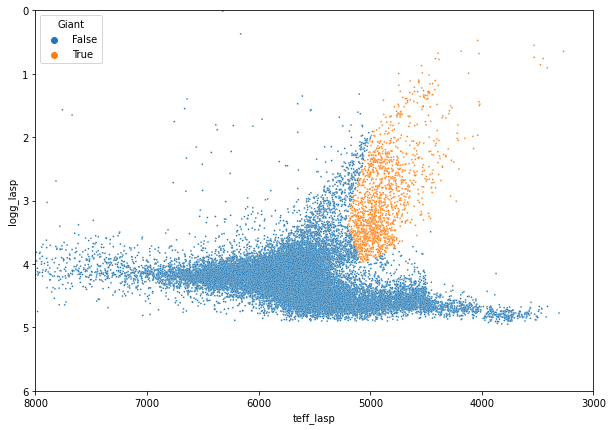

In [6]:
plt.figure(figsize=(10,7))
sns.scatterplot('teff_lasp', 'logg_lasp', data=lamost_data_df, hue = 'Giant', s = 3)
plt.ylim(6,0)
plt.xlim(8000, 3000)
#plt.savefig('/Users/mncavieres/Documents/2024-1/Delve/Plots/keils_diam_lamost.pdf')
plt.show()

In [32]:
# load isochrone
isochrone = pd.read_csv('/Users/mncavieres/Documents/2024-1/Delve/Data/isochrones/-0.9dex_10Gyr.csv')
# select RGB in isochrone
isochrone_lmc_rgb = isochrone.loc[(isochrone['label'] == 3)]
# drop first 5 and last 5 points
isochrone_lmc_rgb = isochrone_lmc_rgb[5:-5]

# select main sequence in isochrone
isochrone_lmc_ms = isochrone.loc[(isochrone['label'] == 1)]
# drop first 5 and last 5 points
isochrone_lmc_ms = isochrone_lmc_ms[5:-5]

# fit polynomial to the isochrone in the giKs color space
coeffs = np.polyfit(isochrone_lmc_rgb['gmag']-isochrone_lmc_rgb['imag'], isochrone_lmc_rgb['imag'] - isochrone_lmc_rgb['Ksmag'], 5)

# fit polynomial to the main sequence in the CMD
coeffs_ms = np.polyfit(isochrone_lmc_ms['gmag']-isochrone_lmc_ms['imag'], isochrone_lmc_ms['imag'] - isochrone_lmc_ms['Ksmag'], 5)



In [24]:
# select giants
giants_lamost = lamost_data_df.loc[lamost_data_df['Giant'] == True]

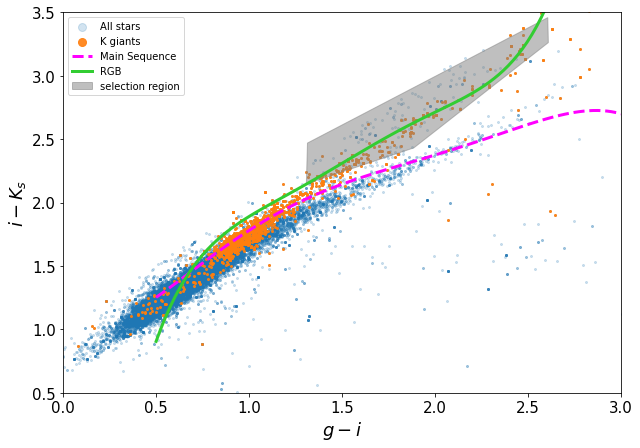

In [56]:
plt.figure(figsize=(10,7))
plt.scatter(lamost_data_df['g_i'], lamost_data_df['i_Ks'], s = 4, alpha = 0.2, label = 'All stars')
plt.scatter(giants_lamost['g_i'], giants_lamost['i_Ks'], s = 4, alpha = 0.9, label = 'K giants')

#, c = lamost_data_df['Giant'])
#sns.scatterplot('g_i', 'i_Ks', data = lamost_data_df, hue = 'Giant', s = 3)


x = np.linspace(0.5, 3, 100)
plt.plot(x, np.polyval(coeffs_ms, x), label = 'Main Sequence', linewidth = 3, linestyle = '--', color = 'magenta')
plt.plot(x, np.polyval(coeffs, x), label = 'RGB', linewidth = 3, color = 'limegreen')

#plt.scatter(isochrone_lmc_rgb['gmag']-isochrone_lmc_rgb['imag'], isochrone_lmc_rgb['imag'] - isochrone_lmc_rgb['Ksmag'], s = 10, c = 'orange')
# make the area grey where the giants are following the vertices of this polygon
# Define vertices
#vertices= ( 1.31,2.15, 1.88,2.43, 3.12,3.86, 1.32,2.47)
vertices = np.array([[1.308, 2.147], [1.886, 2.431], [2.609, 3.261], [2.606, 3.458], [1.314, 2.469]])

# grey out area within vertices

# Unpacking the vertices into x and y components
x_polygon, y_polygon = vertices[:, 0], vertices[:, 1]
plt.fill(x_polygon, y_polygon, label =  'selection region', alpha=0.5, color = 'grey')  # Filling the polygon region with grey


plt.xlim(0, 3)
plt.ylim(0.5, 3.5)
# change size of xticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('$g - i$', fontsize=18)
plt.ylabel('$i - K_s$', fontsize=18)
plt.legend()
# make the legend markers bigger
plt.legend(markerscale=4)
plt.savefig('/Users/mncavieres/Documents/2024-1/Delve/Proposal/Plots/gi_iks_selection.png')
plt.show()


## Fancier plot

In [ ]:
plt.figure(figsize=(10,7))
#plt.scatter(lamost_data_df['g_i'], lamost_data_df['i_Ks'], s = 2, c = lamost_data_df['Giant'])
sns.scatterplot('g_i', 'i_Ks', data = lamost_data_df, hue = 'Giant', s = 3)
x = np.

plt.xlim(-1, 4)
plt.ylim(0.5, 4)
plt.xlabel('$g - i$')
plt.ylabel('$i - K_s$')
plt.savefig('/Users/mncavieres/Documents/2024-1/Delve/Proposal/Plots/gi_iks_selection.pdf')
plt.show()


## Define training set

In [21]:
# Define training set
training_set = lamost_data_df.loc[(lamost_data_df['g_i']>-1)& (lamost_data_df['g_i']<4)
                                  & (lamost_data_df['i_Ks']>0.5) & (lamost_data_df['i_Ks']< 4)]

# and 'g_i' and 'i_Ks' are columns for features, and 'Giant' is the label
X = training_set[['g_i', 'i_Ks']]
y = training_set['Giant']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Standardizing the features (important for SVM and can benefit other classifiers)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Now the data is ready for the classifiers!
# This scaling must also be performed when using the classifiers

/Users/mncavieres/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='g_i', ylabel='i_Ks'>

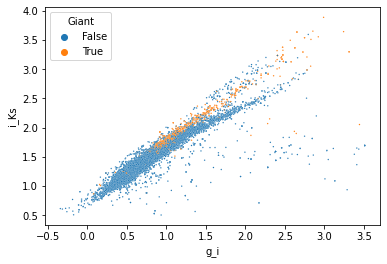

In [22]:
sns.scatterplot('g_i', 'i_Ks',data =  training_set, hue='Giant', s = 2)

## SVM classifier

In [23]:
# Creating classifier instance
svm_classifier = SVC(kernel='rbf')  # Using an radial basis function kernel

# Training the classifiers
svm_classifier.fit(X_train_scaled, y_train)


# Predicting the test set results
svm_predictions = svm_classifier.predict(X_test_scaled)

# Calculating precision and recall
svm_precision = precision_score(y_test, svm_predictions)
svm_recall = recall_score(y_test, svm_predictions)

print("SVM Precision:", svm_precision, "SVM Recall:", svm_recall)

SVM Precision: 0.696969696969697 SVM Recall: 0.21100917431192662


In [24]:
# test all kernels

# SVM kernels to evaluate
kernels = ['linear', 'rbf', 'sigmoid']

# Loop through each kernel type, train, and evaluate the SVM
for kernel in kernels:
    svm_classifier = SVC(kernel=kernel)
    svm_classifier.fit(X_train_scaled, y_train)
    svm_predictions = svm_classifier.predict(X_test_scaled)
    
    # Calculating precision and recall
    svm_precision = precision_score(y_test, svm_predictions)
    svm_recall = recall_score(y_test, svm_predictions)
    
    print(f"SVM Kernel: {kernel}, Precision: {svm_precision}, Recall: {svm_recall}")

/Users/mncavieres/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM Kernel: linear, Precision: 0.0, Recall: 0.0
SVM Kernel: rbf, Precision: 0.696969696969697, Recall: 0.21100917431192662
SVM Kernel: sigmoid, Precision: 0.18991097922848665, Recall: 0.19571865443425077


## Random Forest

In [25]:
# Creating classifier instance
rf_classifier = RandomForestClassifier(n_estimators=500)

# Training classifer
rf_classifier.fit(X_train, y_train)

# Predicting the test set results
rf_predictions = rf_classifier.predict(X_test)

# Calculating precision and recall
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)


print("Random Forest Precision:", rf_precision, "Random Forest Recall:", rf_recall)

Random Forest Precision: 0.7647058823529411 Random Forest Recall: 0.636085626911315


## Gradient Boosting

In [26]:
# Creating classifier instance
gb_classifier = GradientBoostingClassifier(n_estimators=500)

# Training classifer
gb_classifier.fit(X_train, y_train)

# Predicting the test set results
gb_predictions = gb_classifier.predict(X_test)


# Calculating precision and recall
gb_precision = precision_score(y_test, gb_predictions)
gb_recall = recall_score(y_test, gb_predictions)


print("Gradient Boosting Precision:", gb_precision, "Gradient Boosting Recall:", gb_recall)


Gradient Boosting Precision: 0.7241379310344828 Gradient Boosting Recall: 0.5137614678899083


## Heuristic

In [27]:
# Define vertices
vertices= ( 1.31,2.15, 1.88,2.43, 3.12,3.86, 1.32,2.47)

# Predicting test set results
hc_predictions = isInside(X_test['g_i'], X_test['i_Ks'], vertices)


# Calculating precision and recall
hc_precision = precision_score(y_test, hc_predictions)
hc_recall = recall_score(y_test, hc_predictions)


print("Heuristic Precision:", hc_precision, "Heuristic Recall:", hc_recall)

Heuristic Precision: 0.5694444444444444 Heuristic Recall: 0.12538226299694188


## Save Model

In [28]:
from joblib import dump, load
# Save the model
dump(rf_classifier, 'rf_Kgiants.joblib')

['rf_Kgiants.joblib']

In [29]:
# This saved model can now be used by

rf_classifier_loaded = load('rf_Kgiants.joblib')

# Predicting the test set results
rf_predictions = rf_classifier_loaded.predict(X_test)

# Calculating precision and recall
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)


print("Random Forest Precision:", rf_precision, "Random Forest Recall:", rf_recall)

Random Forest Precision: 0.7647058823529411 Random Forest Recall: 0.636085626911315


## Visualize the selections

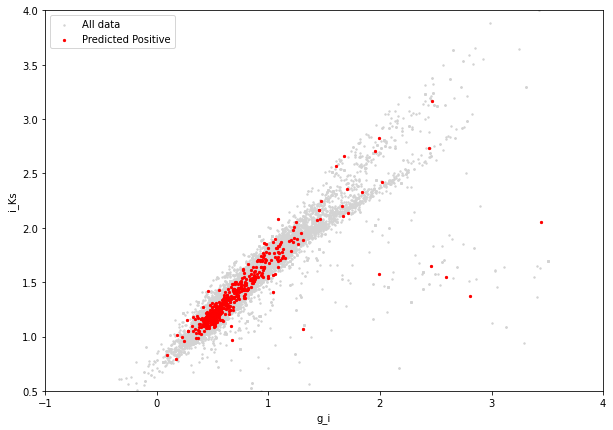

In [30]:
# Assuming gb_classifier is already trained and X_train_scaled is ready
gb_predictions = gb_classifier.predict(X_train_scaled)

# Assuming 'lamost_data_df' holds the original unscaled data corresponding to X_train
plt.figure(figsize=(10,7))

# Plot all points in light gray to show the full dataset
plt.scatter(lamost_data_df['g_i'], lamost_data_df['i_Ks'], s=2, color='lightgray', label='All data')

# Extract and plot only the points that were predicted as a specific class (e.g., '1' for positive)
# First, ensure that your dataframe has the same indexing as your training data
predicted_indices = np.where(gb_predictions == 1)  # Adjust the condition based on your classifier's needs
predicted_data = lamost_data_df.iloc[predicted_indices]

plt.scatter(predicted_data['g_i'], predicted_data['i_Ks'], s=5, color='red', label='Predicted Positive')

# Set limits and labels
plt.xlim(-1, 4)
plt.ylim(0.5, 4)
plt.xlabel('g_i')
plt.ylabel('i_Ks')
plt.legend()
plt.show()

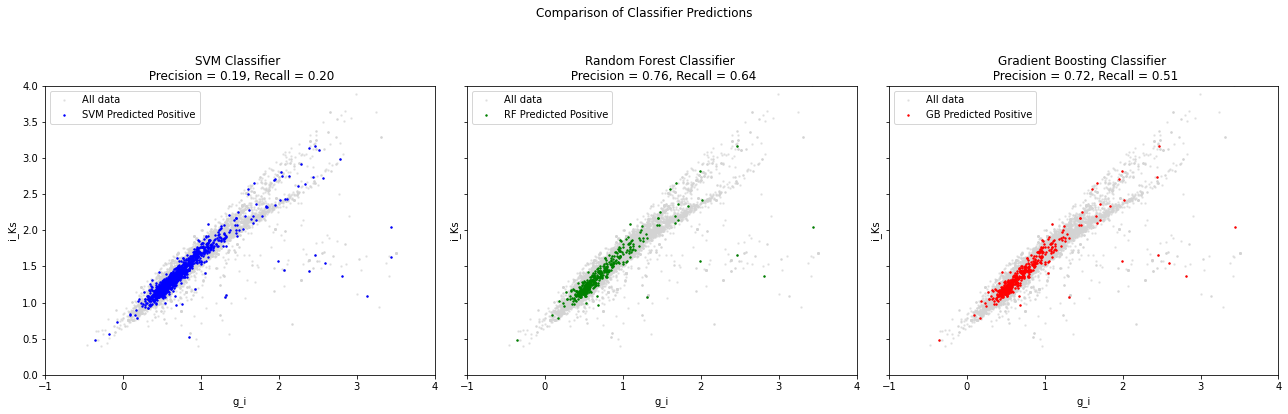

In [34]:

# Make predictions using each classifier
svm_predictions = svm_classifier.predict(X_train_scaled)
rf_predictions = rf_classifier.predict(X_train_scaled)  # Assuming no scaling was used
gb_predictions = gb_classifier.predict(X_train_scaled)  # Assuming no scaling was used

# Prepare the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # 1 row, 3 columns
fig.suptitle('Comparison of Classifier Predictions')

# Define common settings for all plots
scatter_settings = {'s': 2, 'alpha': 0.5}
pred_settings = {'s': 2}

# SVM Plot
axes[0].scatter(lamost_data_df['g_i'], lamost_data_df['i_Ks'], color='lightgray', **scatter_settings, label='All data')
svm_positives = lamost_data_df.iloc[np.where(svm_predictions == 1)]
axes[0].scatter(svm_positives['g_i'], svm_positives['i_Ks'], color='blue',  **pred_settings, label='SVM Predicted Positive')
axes[0].set_title('SVM Classifier \n Precision = {:.2f}, Recall = {:.2f}'.format(svm_precision, svm_recall))
axes[0].set_xlabel('g_i')
axes[0].set_ylabel('i_Ks')

# Random Forest Plot
axes[1].scatter(lamost_data_df['g_i'], lamost_data_df['i_Ks'], color='lightgray', **scatter_settings, label='All data')
rf_positives = lamost_data_df.iloc[np.where(rf_predictions == 1)]
axes[1].scatter(rf_positives['g_i'], rf_positives['i_Ks'], color='green', **pred_settings, label='RF Predicted Positive')
axes[1].set_title('Random Forest Classifier \n Precision = {:.2f}, Recall = {:.2f}'.format(rf_precision, rf_recall))
axes[1].set_xlabel('g_i')
axes[1].set_ylabel('i_Ks')

# Gradient Boosting Plot
axes[2].scatter(lamost_data_df['g_i'], lamost_data_df['i_Ks'], color='lightgray', **scatter_settings, label='All data')
gb_positives = lamost_data_df.iloc[np.where(gb_predictions == 1)]
axes[2].scatter(gb_positives['g_i'], gb_positives['i_Ks'], color='red', **pred_settings, label='GB Predicted Positive')
axes[2].set_title('Gradient Boosting Classifier \n Precision = {:.2f}, Recall = {:.2f}'.format(gb_precision, gb_recall))
axes[2].set_xlabel('g_i')
axes[2].set_ylabel('i_Ks')

# Add legends and adjust layout
for ax in axes:
    ax.legend()
    ax.set_xlim(-1,4)
    ax.set_ylim(0, 4)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect to leave space for the global title

# Show the plot
plt.savefig('/Users/mncavieres/Documents/2024-1/Delve/Plots/Classifier_Comparison_3.png', dpi = 600)
plt.show()


## Apply to real VHS DELVE data

In [40]:
# load data 

delve = Table.read('/Users/mncavieres/Documents/2024-1/Delve/Data/test/delve/delve_x_vhs_6.301225539313727_7.5135345254137516_-4.400372670147675_-2.9174236631788677.dat', format='ascii')

In [41]:
delve['g_i'] = delve['mag_psf_g'] - delve['mag_psf_i']
delve['i_Ks'] = delve['mag_psf_i'] - delve['KSAPERMAG3']

In [42]:
delve = delve.to_pandas()

In [43]:
delve.to_csv('/Users/mncavieres/Documents/2024-1/Delve/Data/test/delve_x_vhs_6.301225539313727_7.5135345254137516_-4.400372670147675_-2.9174236631788677.csv')

In [37]:
# Check for NaN values and handle them
delve = delve.dropna(subset=['g_i', 'i_Ks'])

# Transform data as the classifier requires normalized data
delve_scaled = scaler.transform(delve[['g_i', 'i_Ks']])

# Predicting with the random forest classifier
predictions = rf_classifier.predict(delve_scaled)

# Optionally, attach predictions back to the dataframe if you need to analyze them further
delve['predictions'] = predictions

In [42]:
giants_rf = delve.loc[predictions]

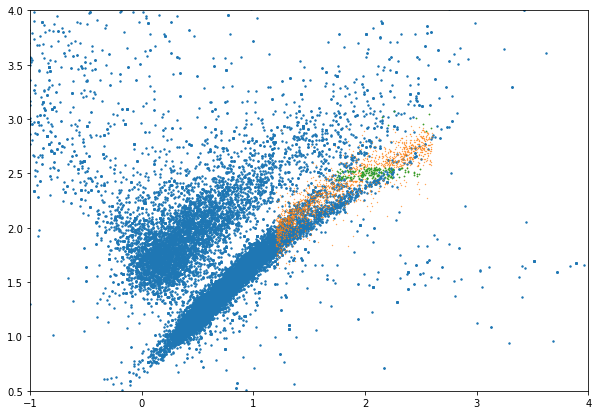

In [46]:
plt.figure(figsize=(10,7))
plt.scatter(lamost_data_df['g_i'], lamost_data_df['i_Ks'], s = 2)
plt.scatter(delve['g_i'], delve['i_Ks'],s = 0.1)
plt.scatter(giants_rf['g_i'], giants_rf['i_Ks'], s = 0.5)
plt.xlim(-1, 4)
plt.ylim(0.5, 4)
plt.show()
